In [170]:
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Container setup from image (multiplier, inhabitants)
containers = [
    {"mult": 10, "inhab": 1},
    {"mult": 80, "inhab": 6},
    {"mult": 37, "inhab": 3},
    {"mult": 17, "inhab": 1},
    {"mult": 31, "inhab": 2},
    {"mult": 50, "inhab": 4},
    {"mult": 89, "inhab": 8},
    {"mult": 73, "inhab": 4},
    {"mult": 20, "inhab": 2},
    {"mult": 90, "inhab": 10}
]

BASE_TREASURE = 10000
N_GEN = 100
ALPHA = 0.05  # Exponential moving average factor
TEMPERATURE = 50000  # Softmax temperature (10,000 - 100,000)
# Low temp = game theory optimal
# High temp = random exploration

n = len(containers)
avg_ev = np.zeros(n)
popularity = np.ones(n)  # Start with equal assumption



In [ ]:
ev_history = []
prob_history = []

for gen in range(50):
    # Step 1: Compute raw EV per container
    raw_ev = np.array([
        BASE_TREASURE * c["mult"] / (c["inhab"] + popularity[i])
        for i, c in enumerate(containers)
    ])
    
    # Step 2: Softmax to simulate player choice distribution
    shifted_ev = raw_ev / (TEMPERATURE)  # Scale by temperature
    shifted_ev -= np.max(shifted_ev)  # For numerical stability
    exp_scaled = np.exp(shifted_ev)
    probs = exp_scaled / np.sum(exp_scaled)
    
    # # Step 2: linear
    # min_ev = raw_ev.min()
    # range_ev = raw_ev.max() - min_ev
    # if range_ev == 0:
    #     probs = np.ones_like(raw_ev) / len(raw_ev)  # fallback if all values are equal
    # else:
    #     scaled = (raw_ev - min_ev) / range_ev
    #     probs = scaled / scaled.sum()
    
    # Step 3: Use these probs as popularity estimates for next round
    popularity = probs * 100

    # Step 4: Compute actual EV with updated popularity
    true_ev = np.array([
        BASE_TREASURE * c["mult"] / (c["inhab"] + popularity[i])
        for i, c in enumerate(containers)
    ])

    # Track for plot
    ev_history.append(true_ev.copy())
    prob_history.append(popularity.copy())
    
ev_history = np.array(ev_history)
prob_history = np.array(prob_history)

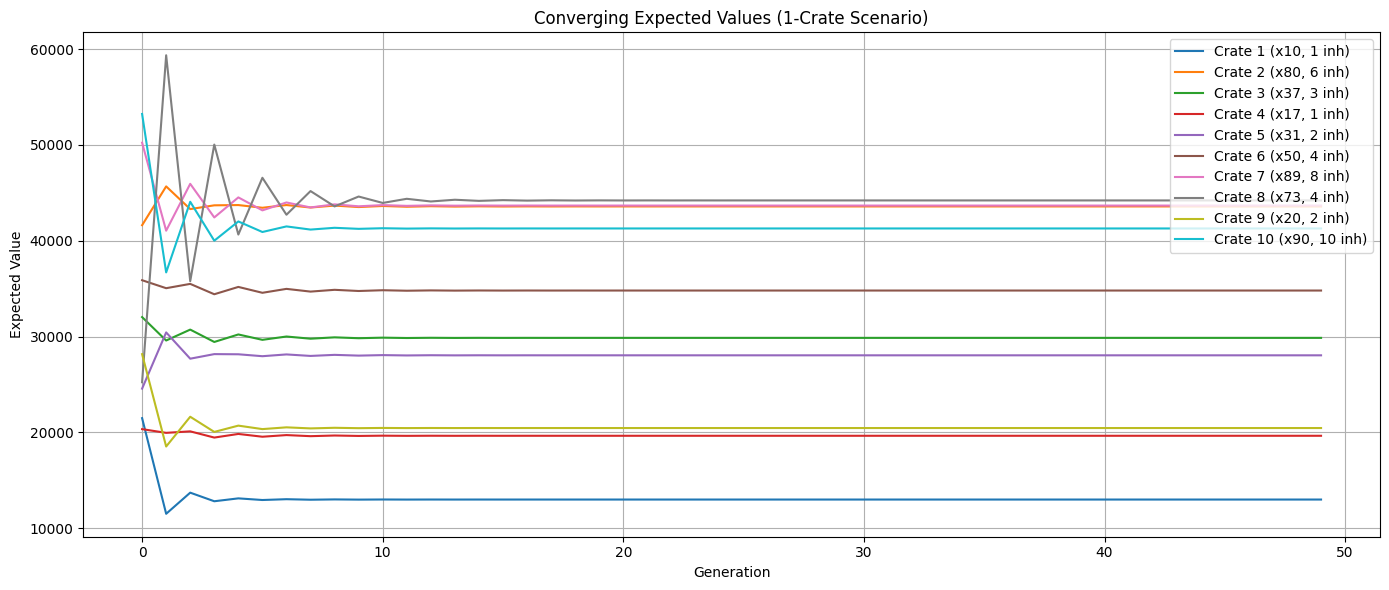

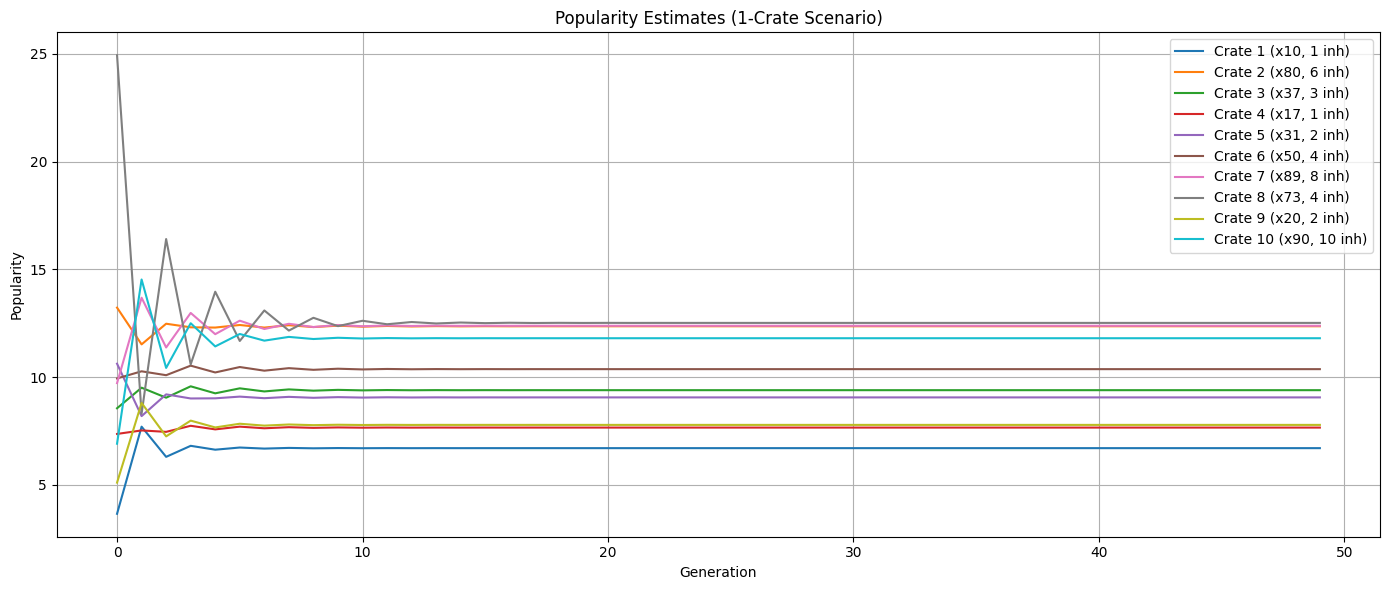

In [137]:
# Plot avg ev
plt.figure(figsize=(14, 6))

for i in range(n):
    plt.plot(ev_history[:, i], label=f"Crate {i+1} (x{containers[i]['mult']}, {containers[i]['inhab']} inh)")

plt.title("Converging Expected Values (1-Crate Scenario)")
plt.xlabel("Generation")
plt.ylabel("Expected Value")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

# plot popularity
plt.figure(figsize=(14, 6))

for i in range(n):
    plt.plot(prob_history[:, i], label=f"Crate {i+1} (x{containers[i]['mult']}, {containers[i]['inhab']} inh)")
    
plt.title("Popularity Estimates (1-Crate Scenario)")
plt.xlabel("Generation")
plt.ylabel("Popularity")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


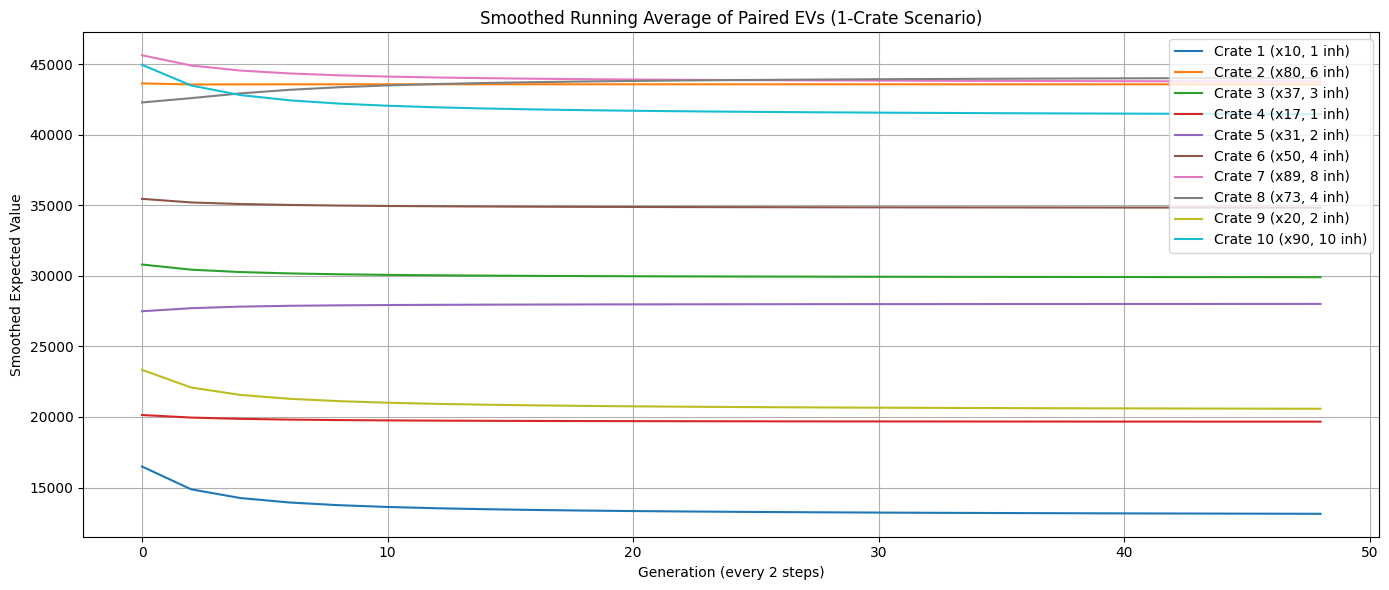

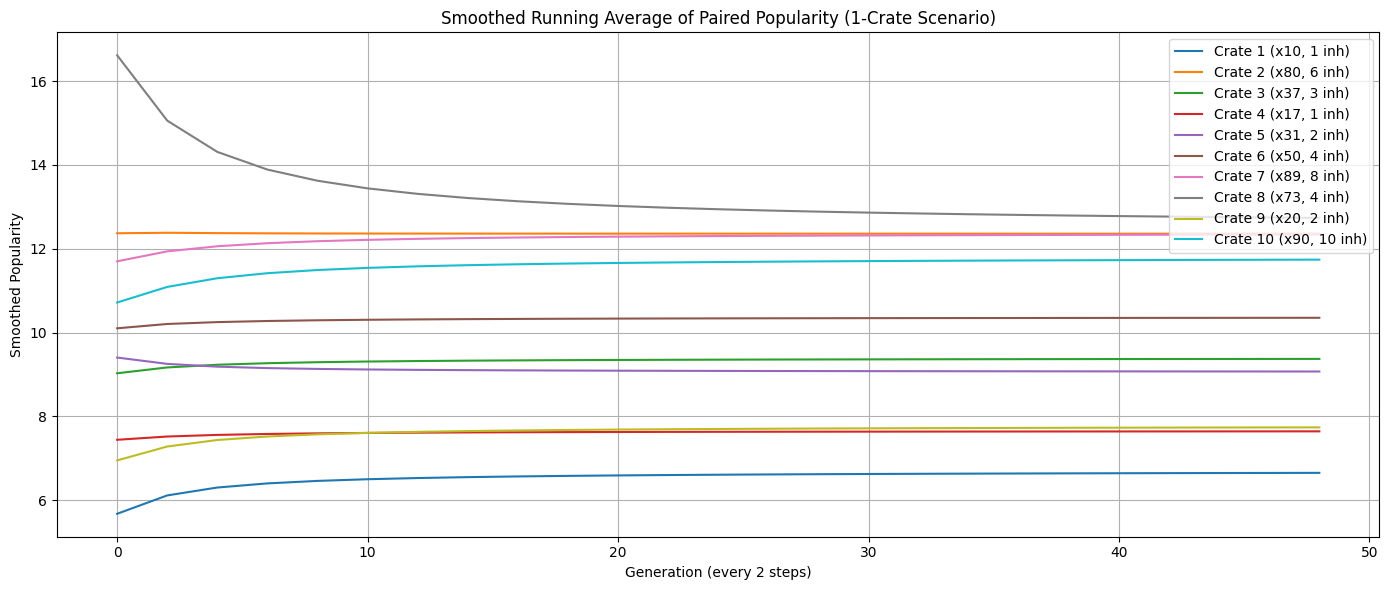

Final Expected Values After Convergence:

      Crate  Multiplier  Inhabitants  Final EV  Final Popularity
0   Crate 8          73            4  44038.19             12.74
1   Crate 7          89            8  43782.55             12.34
2   Crate 2          80            6  43582.14             12.36
3  Crate 10          90           10  41469.43             11.74
4   Crate 6          50            4  34839.78             10.35
5   Crate 3          37            3  29911.52              9.37
6   Crate 5          31            2  28015.38              9.07
7   Crate 9          20            2  20584.63              7.74
8   Crate 4          17            1  19669.40              7.64
9   Crate 1          10            1  13138.04              6.65


In [138]:
# Average every 2 consecutive generations (pair smoothing)
paired_avg_ev = (ev_history[::2] + ev_history[1::2]) / 2

# Compute running average of paired EVs
running_avg_ev = np.cumsum(paired_avg_ev, axis=0) / np.arange(1, len(paired_avg_ev) + 1)[:, None]

# Plot the running average of paired EVs
plt.figure(figsize=(14, 6))
for i in range(n):
    plt.plot(np.arange(len(running_avg_ev)) * 2, running_avg_ev[:, i],
             label=f"Crate {i+1} (x{containers[i]['mult']}, {containers[i]['inhab']} inh)")

plt.title("Smoothed Running Average of Paired EVs (1-Crate Scenario)")
plt.xlabel("Generation (every 2 steps)")
plt.ylabel("Smoothed Expected Value")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

# average popularity every 2 consecutive generations (pair smoothing)
paired_avg_pop = (prob_history[::2] + prob_history[1::2]) / 2

running_avg_pop = np.cumsum(paired_avg_pop, axis=0) / np.arange(1, len(paired_avg_pop) + 1)[:, None]

# Plot the running average of paired popularity
plt.figure(figsize=(14, 6))
for i in range(n):
    plt.plot(np.arange(len(running_avg_pop)) * 2, running_avg_pop[:, i],
             label=f"Crate {i+1} (x{containers[i]['mult']}, {containers[i]['inhab']} inh)")
    
plt.title("Smoothed Running Average of Paired Popularity (1-Crate Scenario)")
plt.xlabel("Generation (every 2 steps)")
plt.ylabel("Smoothed Popularity")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Get the final EVs from the last running average row
final_running_evs = running_avg_ev[-1]
final_running_pop = running_avg_pop[-1]

# Build and sort a DataFrame to display
final_df = pd.DataFrame({
    "Crate": [f"Crate {i+1}" for i in range(n)],
    "Multiplier": [c["mult"] for c in containers],
    "Inhabitants": [c["inhab"] for c in containers],
    "Final EV": final_running_evs,
    "Final Popularity": final_running_pop
}).sort_values("Final EV", ascending=False).reset_index(drop=True)

print("Final Expected Values After Convergence:\n")
print(final_df.round(2))



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Container setup
containers = [
    {"mult": 10, "inhab": 1},
    {"mult": 80, "inhab": 6},
    {"mult": 37, "inhab": 3},
    {"mult": 17, "inhab": 1},
    {"mult": 31, "inhab": 2},
    {"mult": 50, "inhab": 4},
    {"mult": 89, "inhab": 8},
    {"mult": 73, "inhab": 4},
    {"mult": 20, "inhab": 2},
    {"mult": 90, "inhab": 10}
]

BASE_TREASURE = 10000
N_GEN = 50
HEDGE_COST = 50000  # Cost of the hedge

# Softmax temperature (10,000 - 100,000)
# Low temp = game theory optimal
# High temp = random 
TEMPERATURE_MAIN = 50000
TEMPERATURE_HEDGE = 50000 

n = len(containers)

# Initial popularity
popularity = np.ones(n)

In [166]:
# Histories
pairwise_ev_history = []
popularity_history = []

for gen in range(1):
    # Step 1: Compute raw EV per container
    raw_ev = np.array([
        BASE_TREASURE * c["mult"] / (c["inhab"] + popularity[i])
        for i, c in enumerate(containers)
    ])
    
    # Step 2: Softmax to simulate player choice distribution (main crate)
    shifted_ev_main = raw_ev / (TEMPERATURE_MAIN)  # Scale by temperature
    shifted_ev_main -= np.max(shifted_ev_main)  # For numerical stability
    exp_scaled_main = np.exp(shifted_ev_main)
    main_probs = exp_scaled_main / np.sum(exp_scaled_main)
    real_main_prob = main_probs * 100

    # Step 3: Calculate player ev for main crate 
    main_ev = np.array([
        BASE_TREASURE * c["mult"] / (c["inhab"] + real_main_prob[i])
        for i, c in enumerate(containers)
    ])
    
    # Step 4: For each main crate, calculate player choice for hedge crate (-cost of hedge)
    pairwise_ev = np.full((n, n), np.nan)
    pairwise_probs = np.zeros((n, n))
    
    for i in range(n):  # main crate
        # Hedge candidates
        hedge_indices = [j for j in range(n) if j != i]
        
        # Subtract the cost of the hedge from the expected value
        hedge_raw_ev = np.array([
            BASE_TREASURE * containers[j]["mult"] / (containers[j]["inhab"] + real_main_prob[i])
            for j in hedge_indices
        ]) - HEDGE_COST
        
        hedge_ev_shifted = hedge_raw_ev / TEMPERATURE_HEDGE
        hedge_ev_shifted -= np.max(hedge_ev_shifted)
        exp_scaled_hedge = np.exp(hedge_ev_shifted)
        hedge_probs = exp_scaled_hedge / np.sum(exp_scaled_hedge)
        expected_hedge_prob = hedge_probs * 100
        
        full_hedge_probs = np.zeros(n)
        for k, j in enumerate(hedge_indices):
            full_hedge_probs[j] = expected_hedge_prob[k]

        for j in range(n):  # hedge crate
            if i != j:
                ev = main_ev[i] + raw_ev[j] - HEDGE_COST
                pairwise_ev[i, j] = ev
                pairwise_probs[i, j] = main_probs[i] * full_hedge_probs[j]
        
    # Total crate popularity from main + hedge roles
    crate_popularity = pairwise_probs.sum(axis=0) + pairwise_probs.sum(axis=1)
    popularity = crate_popularity
        
    pairwise_ev_history.append(pairwise_ev.copy())
    popularity_history.append(crate_popularity.copy())

pairwise_ev_history = np.array(pairwise_ev_history)
popularity_history = np.array(popularity_history)        

NameError: name 'sns' is not defined

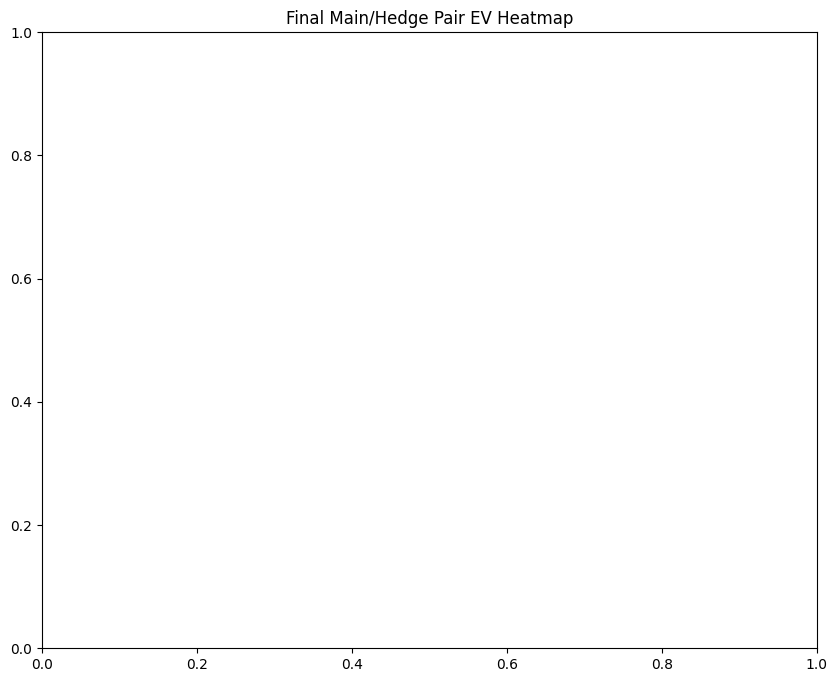

In [ ]:
final_ev = pd.DataFrame(
    pairwise_ev_history[-1],
    columns=[f"Hedge {i+1}" for i in range(n)],
    index=[f"Main {i+1}" for i in range(n)]
)
plt.figure(figsize=(10, 8))
plt.title("Final Main/Hedge Pair EV Heatmap")
sns.heatmap(final_ev, annot=True, fmt=".0f", cmap="YlGnBu")
plt.tight_layout()
plt.show()